# Analysis of discrimination across datasets/classifier predictions

In [1]:
%load_ext autoreload
%autoreload 
import plots
import metrics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utlis import standardize_metrics
from model_fitting import logistic_model
from synthetic_generator import SyntheticLoanDataGenerator
sns.set_style("whitegrid")  
sns.set_context("paper", font_scale=1.6)
pd.set_option('display.max_columns', 10)
pd.set_option("display.precision", 5)



In [2]:
from tueplots import bundles
bundles.aaai2024()
plt.rcParams.update(bundles.aaai2024())
# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 800})

In [3]:
sensitive_attributes = ['Gender', 'Race']
outcome_col = 'Y'
results = {}
scaling_method='MinMax'
sensitivity_scaling_method='MinMax'
mode = 'MAD'


### Dataset with no discrimination

In [4]:
no_bias = pd.read_csv('synthetic_data/no_discri_lambda_10000.csv')
nobias_metrics_results, no_biaseval_subgroup_rates = metrics.evaluation_data(no_bias, sensitive_attributes, outcome_col, mode)
results['No bias'] = nobias_metrics_results

In [5]:
pd.crosstab(no_bias['Gender'], no_bias['Race'])


# from sklearn.metrics import matthews_corrcoef
# matthews_corrcoef(no_bias['Gender'], no_bias['Race'])

Race,0,1
Gender,,
0,2538,2496
1,2515,2451


In [6]:
import numpy as np
import pandas as pd
from metrics import compute_idd_metric

def bootstrap_intersectional_disparity(
    df, outcome_col, sensitive_attributes, metric_fn, n_bootstrap=1000, ci=95, seed=42
):
    np.random.seed(seed)
    estimates = []

    for _ in range(n_bootstrap):
        sample_df = df.sample(frac=1.0, replace=True)
        _, _, interaction = metric_fn(sample_df, outcome_col, sensitive_attributes)
        estimates.append(interaction)

    # Compute CI
    lower = np.percentile(estimates, (100 - ci) / 2)
    upper = np.percentile(estimates, 100 - (100 - ci) / 2)
    mean_estimate = np.mean(estimates)

    return {
        "mean": mean_estimate,
        f"{ci}% CI": (lower, upper),
        "std": np.std(estimates),
        "all_estimates": estimates  # Optional for histogram plot
    }
    
    
result = bootstrap_intersectional_disparity(
    df=no_bias,
    outcome_col='Y',
    sensitive_attributes=['Gender', 'Race'],
    metric_fn=compute_idd_metric,
    n_bootstrap=1000
)

print(result)



{'mean': 0.03682416020497623, '95% CI': (0.004283279868675813, 0.07460796914950629), 'std': 0.0184016708888148, 'all_estimates': [0.0577001765862325, 0.004962169109261505, 0.03984067403922442, 0.0726471116939591, 0.026732123026351695, 0.06731416336864943, 0.059847362117877445, 0.013461833617263108, 0.04224890309423357, 0.08961939643916322, 0.0114168747963182, 0.04579581630432833, 0.00604869501251365, 0.03164014062048531, 0.03873684343649947, 0.027220851292901027, 0.06605755419622689, 0.021199555231172118, 0.031115749165366746, 0.013615119161183742, 0.042547251398341424, 0.06014308718693151, 0.04325477888947987, 0.05356340952090605, 0.0367575176272516, 0.05266096191319575, 0.004655050313287334, 0.0444487999027573, 0.037203372588715755, 0.04918090268030689, 0.03809183283290718, 0.032922244808652024, 0.028523798913484055, 0.030396083306460597, 0.011199734687156626, 0.04495737435491043, 0.05500870731043306, 0.025930518217928966, 0.025383069202191688, 0.0655878180763853, 0.01530969105845359

In [7]:
# import seaborn as sns
# sns.boxplot(data=no_bias, x="Gender", y=outcome_col, hue="Race")

# pd.crosstab(no_bias['Gender'], no_bias['Race'], normalize='all')



### Dataset with Single discrimination

In [8]:
single_discrimination = pd.read_csv('synthetic_data/single_discri_tg_10000.csv')
single_bias_results, single_subgroup_rates = metrics.evaluation_data(single_discrimination, sensitive_attributes, outcome_col, mode)
results['Single-axis bias'] = single_bias_results

In [9]:
# matthews_corrcoef(single_discrimination['Gender'], single_discrimination['Race'])

In [10]:
    
result = bootstrap_intersectional_disparity(
    df=single_discrimination,
    outcome_col='Y',
    sensitive_attributes=['Gender', 'Race'],
    metric_fn=compute_idd_metric,
    n_bootstrap=1000
)

print(result)

{'mean': 0.02954155444094657, '95% CI': (0.0016350140149616944, 0.06609301970924603), 'std': 0.01744630016447414, 'all_estimates': [0.04666746515054904, 0.001122395901614559, 0.0382880857369533, 0.04395862267480671, 0.017645884796213873, 0.05482439319243371, 0.05050909104106638, 0.012800246994697728, 0.034357391863697684, 0.07072401706327597, 0.02543637726782433, 0.03553774256199743, 0.020190503311679764, 0.017892418061501103, 0.04396888478517558, 0.008918119372619049, 0.04964163017285633, 0.020687412073014444, 0.030854382055894913, 0.014429271669269772, 0.031309738511285434, 0.06249571513412122, 0.021884073891570766, 0.03709455058700595, 0.017315962075922287, 0.02731225650498209, 0.015758876108831255, 0.012622887225236412, 0.01491086184843099, 0.029909730656922373, 0.03453370183111937, 0.011498862782015784, 0.0006169167224234773, 0.012420973075722708, 0.00887172473980763, 0.027809881974922845, 0.041960714004393496, 0.03252074820926648, 0.019089539273777045, 0.03792783545235956, 0.0063

### Dataset with Multiple Discrimination

In [11]:
multiple_discrimination =pd.read_csv('synthetic_data/multiple_discri_tg_10000.csv')
multiple_bias_results, multiple_subgroup_rates = metrics.evaluation_data(multiple_discrimination, sensitive_attributes, outcome_col, mode)
results['Multiple bias'] = multiple_bias_results

In [12]:
# matthews_corrcoef(multiple_discrimination['Gender'], multiple_discrimination['Race'])

### Dataset with Intersectional Discrimination

In [13]:
intersectional_discrimination = pd.read_csv('synthetic_data/only_intersectional_discri_tg10000.csv')
intersectional_bias_results, intersectional_subgroup_rates = metrics.evaluation_data(intersectional_discrimination, sensitive_attributes, outcome_col,mode)
results['Intersectional bias'] = intersectional_bias_results

In [14]:
# matthews_corrcoef(intersectional_discrimination['Gender'], intersectional_discrimination['Race'])

In [15]:
df = intersectional_discrimination
print("P(Y=1 | G=1, R=0):", df[(df['Gender'] == 1) & (df['Race'] == 0)]['Y'].mean())
print("P(Y=1 | G=0, R=1):", df[(df['Gender'] == 0) & (df['Race'] == 1)]['Y'].mean())


P(Y=1 | G=1, R=0): 0.46878727634194833
P(Y=1 | G=0, R=1): 0.4583333333333333


### Dataset with Compounded Discrimination


In [16]:
compound_discrimination = pd.read_csv('synthetic_data/compounded_discri_tg10000.csv')
compound_bias_results, compound_subgroup_rates = metrics.evaluation_data(compound_discrimination, sensitive_attributes, outcome_col,mode)
results['Compounded bias'] = compound_bias_results

In [17]:
# matthews_corrcoef(compound_discrimination['Gender'], compound_discrimination['Race'])

### Plot the metrics 

In [18]:
# results
dpi = 1200

# pd.DataFrame.from_dict(results, orient='index')

/Users/kanubalad/Desktop/Saarland/PhD_Research/PythonCodes/ThesisWork/MultidimensionalDiscriminationAnalysis/plots.py:310: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


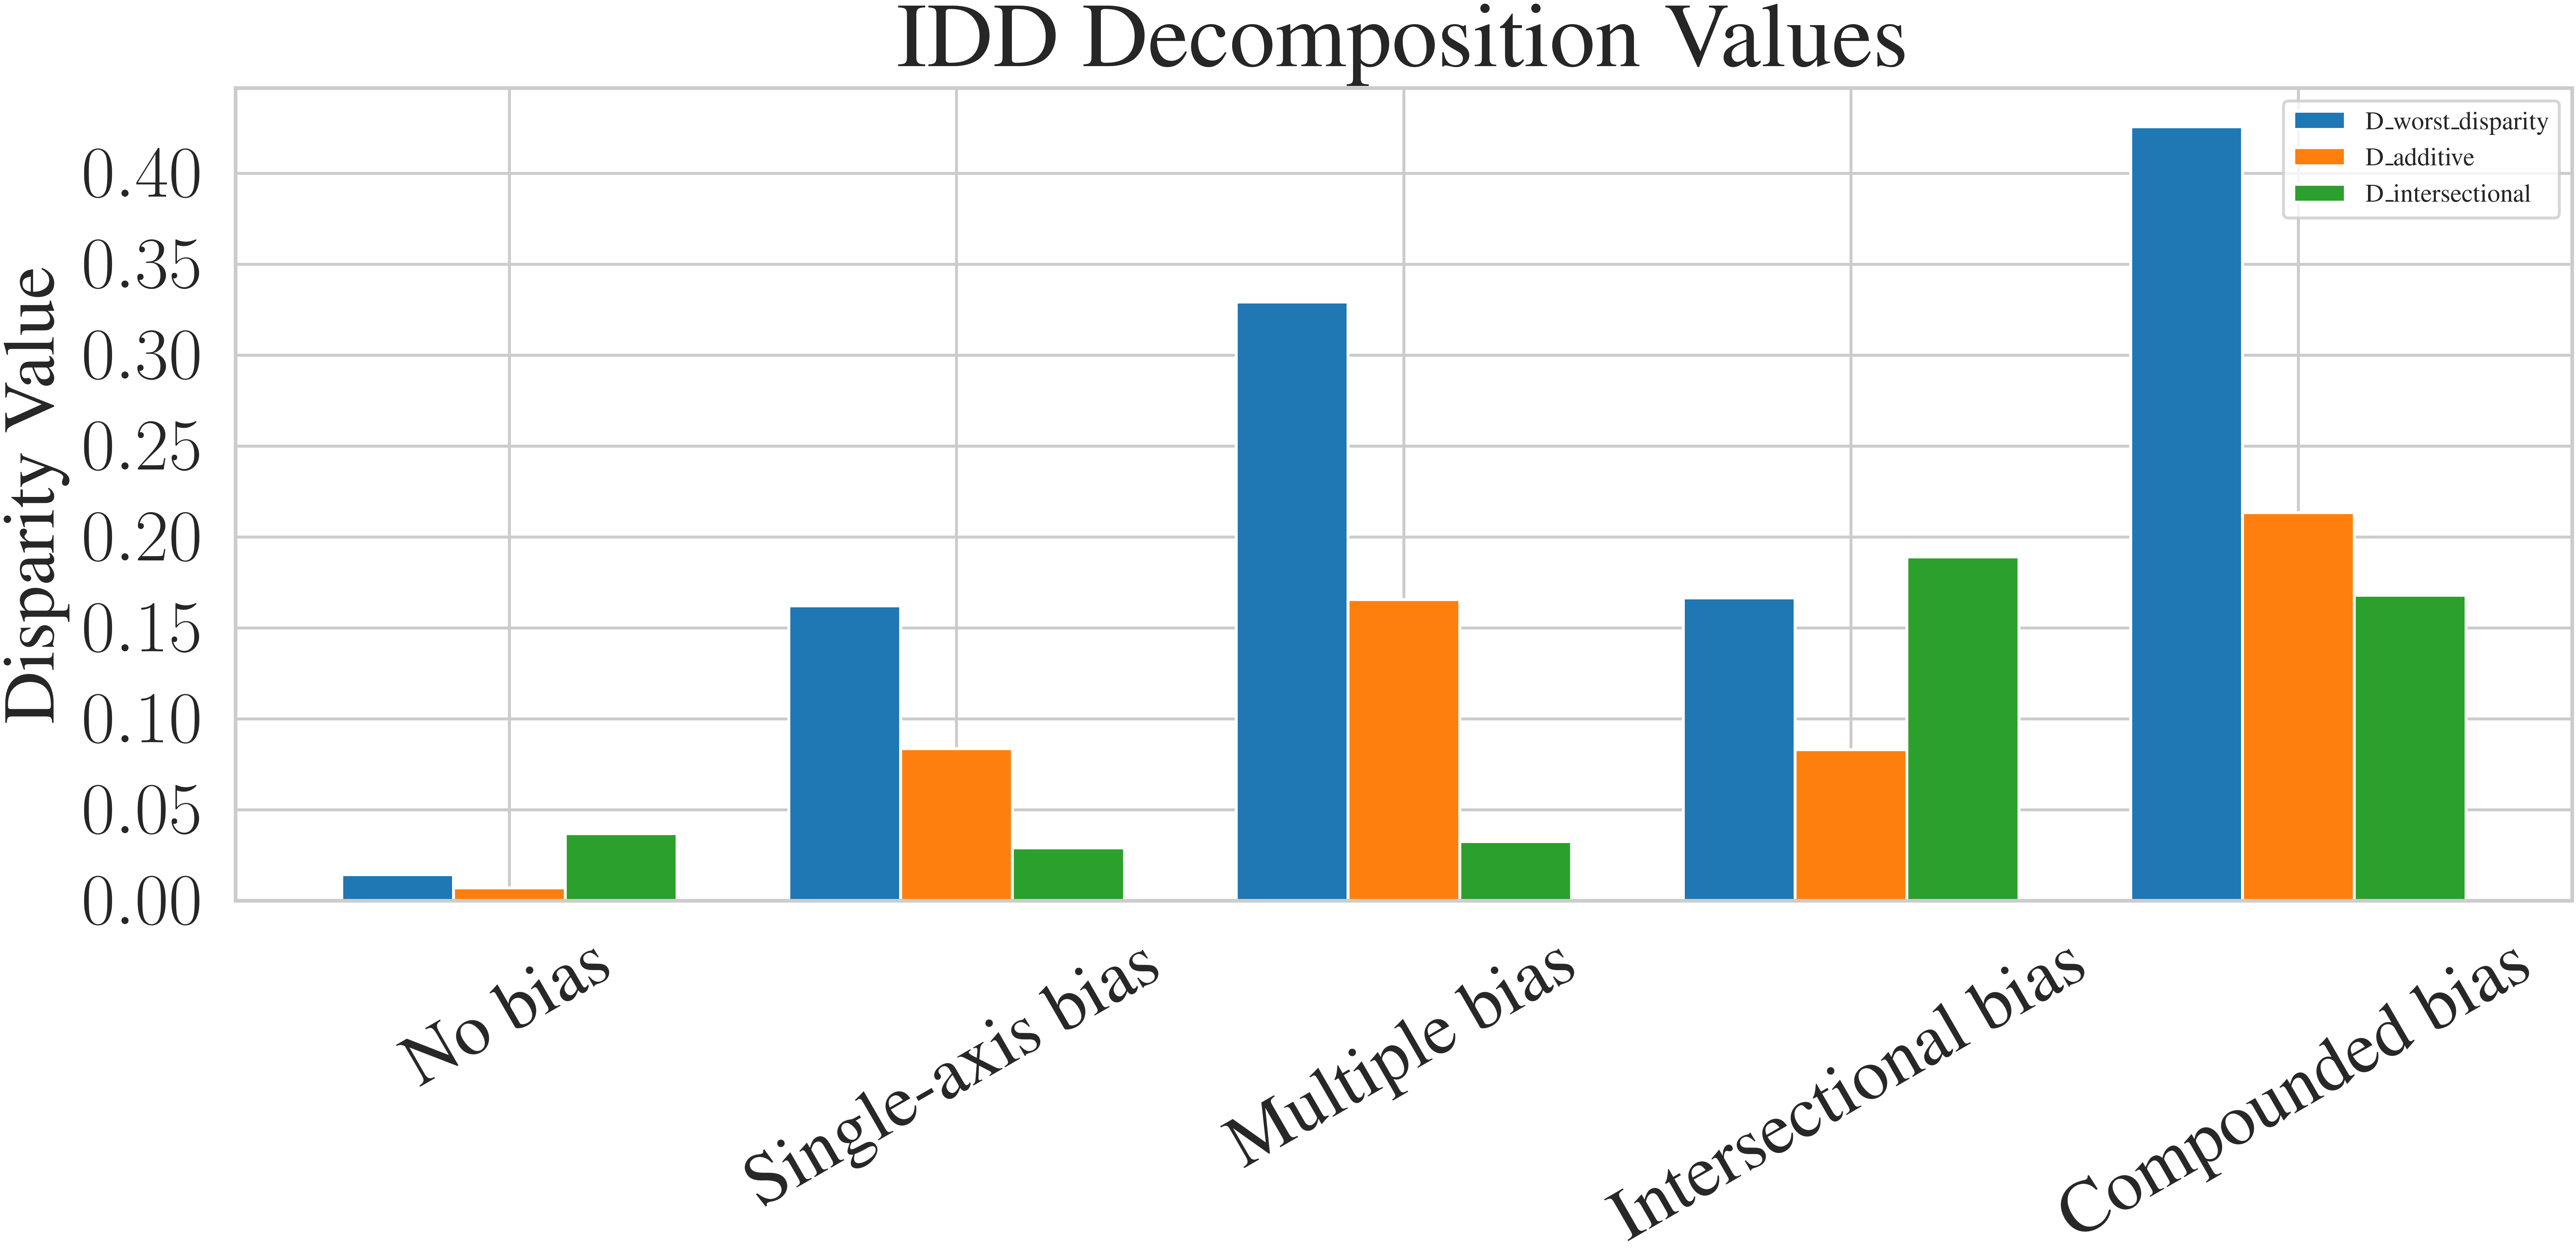

In [19]:
plots.plot_idd_decomposition(results)

In [20]:
# if scaling_method == 'none':
#     plots.plot_metrics(results, output_file='intersectional_fairness_metrics_on_data.pdf', data_type = 'Generated Data',  dpi=dpi)

# else:
#     scaled_results = standardize_metrics(results, scalar_type=scaling_method)
#     plots.plot_metrics(scaled_results, output_file='intersectional_fairness_metrics_on_data.pdf', data_type = 'Generated Data',  dpi=dpi, scaling_method=scaling_method)
    



## ANALYSIS ON THE CLASSIFIERS

In [21]:
get_summary = False
split_data = True
classifier_results = {}
outcome_col = 'y_true'
prediction_col = 'y_hat'
metrics_classifier = {}

### No Bias Data

In [22]:
df_nobias, metrics_nobias = logistic_model(no_bias, get_summary=get_summary, split_data=split_data)
nobias_results, nosubgroup_rates = metrics.evaluation_classifier(df_nobias, sensitive_attributes, outcome_col, prediction_col, mode)
classifier_results['No bias'] = nobias_results
metrics_classifier['No bias'] = metrics_nobias

Optimization terminated successfully.
         Current function value: 0.136781
         Iterations 10


### Single Axis Discrimination

In [23]:
df_single, metrics_single = logistic_model(single_discrimination, get_summary=get_summary, split_data=split_data)
singlebias_results, singlesubgroup_rates = metrics.evaluation_classifier(df_single, sensitive_attributes, outcome_col, prediction_col,mode)
classifier_results['Single-axis bias'] = singlebias_results
metrics_classifier['Single-axis bias'] = metrics_single

Optimization terminated successfully.
         Current function value: 0.153522
         Iterations 10


### Multiple Discrimination

In [24]:

df_multiple, metrics_multiple = logistic_model(multiple_discrimination, get_summary=get_summary, split_data=split_data)

multiplebias_results, multiplesubgroup_rates = metrics.evaluation_classifier(df_multiple, sensitive_attributes, outcome_col, prediction_col,mode)
classifier_results['Multiple bias'] = multiplebias_results
metrics_classifier['Multiple bias'] = metrics_multiple

Optimization terminated successfully.
         Current function value: 0.142888
         Iterations 10


### Intesectionality Discrimination

In [25]:
df_intersectionality, metrics_intersectionality = logistic_model(intersectional_discrimination, get_summary=get_summary, split_data=split_data)

intersectionbias_results, multiplesubgroup_rates = metrics.evaluation_classifier(df_intersectionality, sensitive_attributes, outcome_col, prediction_col,mode)
classifier_results['Intersectional bias'] = intersectionbias_results
metrics_classifier['Intersectional bias'] = metrics_intersectionality

Optimization terminated successfully.
         Current function value: 0.148450
         Iterations 10


#### Compounded Discrimination

In [26]:
df_compound, metrics_compound = logistic_model(compound_discrimination, get_summary=get_summary, split_data=split_data)

compoundbias_results, compoundsubgroup_rates = metrics.evaluation_classifier(df_compound, sensitive_attributes, outcome_col, prediction_col,mode)
classifier_results['Compounded bias'] = compoundbias_results
metrics_classifier['Compounded bias'] = metrics_compound
# predictions__compound, probabilities__compound, metrics_compound = logistic_model(compound_discrimination, get_summary=get_summary, split_data=split_data)

Optimization terminated successfully.
         Current function value: 0.138560
         Iterations 10


In [27]:
# plots.plot_grouped_metrics(metrics_classifier, title = 'Evaluation Metrics of the ', output_file='classifier_evaluation.pdf', data_type='Classifier Predictions', dpi=600)

# if scaling_method == 'none':
#     plots.plot_metrics(classifier_results, output_file='intersectional_fairness_classifier_on_classifier.pdf', data_type = 'Classifier Predictions',  dpi=dpi)

# else:
#     scaled_results_classifier = standardize_metrics(classifier_results, scalar_type=scaling_method)
#     plots.plot_grouped_metrics(scaled_results_classifier, output_file='intersectional_fairness_classifier_on_classifier.pdf', data_type = 'Classifier Predictions',  dpi=dpi, scaling_method=scaling_method)
    

### Sensitivity to Single

In [28]:
base_profile = {"E": 0.25, "I": 2.0, "L": 7.0, "D": 6.3, "Y": 0.8}
scales = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0, 1.2]

gender_bias_profiles = [
    {k: round(v * s, 2) for k, v in base_profile.items()} for s in scales]

outcome_col = 'Y'


sample_size = 10000
random_seed = 42
prob_gender = 0.5
prob_race = 0.5
beta_S = 0.6
beta_I = 0.8
beta = 0.03 # account influence of I, S in L
gamma = 0.10 # if set to 0 then no effect from sensitive attributes, 0.15
delta = 0.75  # influence of L, D in Y
eta = 2.0
plot_intersectional=True


all_results = []
for i, profile in enumerate(gender_bias_profiles):
    thetas = {'G': profile['E'], 'R': 0.0, 'GR': 0.0}
    beta_coef = {'G': profile['I'], 'R': 0.0, 'GR': 0.0}
    rhos = {'G': profile['L'], 'R': 0.0, 'GR': 0.0}
    kappas = {'G': profile['D'], 'R': 0.0, 'GR': 0.0}
    nus = {'G': profile['Y'], 'R': 0.0, 'GR': 0.0}
    lambdas = {'E': 1.0, 'I': 1.0, 'L': 1.0, 'D': -1.0, 'Y': 1.0}
    
    # Generate data and evaluate metrics
    generator = SyntheticLoanDataGenerator(
        sample_size=sample_size,
        random_seed=random_seed,
        prob_gender=prob_gender,
        prob_race=prob_race,
        beta=beta, beta_I=beta_I, beta_S=beta_S,
        gamma=gamma, eta=eta, delta=delta,
        measure_bias_col='Gender',
        thetas=thetas, beta_coef=beta_coef,
        rhos=rhos, kappas=kappas, nus=nus,
        lambdas=lambdas
    )

    data_intersectional = generator.synthetic_data_generation()
    intersectional_df = data_intersectional['data_df']
    
    results_gender, subgroup_rates_gender = metrics.evaluation_data(intersectional_df, sensitive_attributes, outcome_col, mode)
    
    profile_results = profile.copy()  # E, I, L, D, Y
    profile_results.update(results_gender)  # Add metrics to the same dict
    all_results.append(profile_results)    
    
df_results_gender = pd.DataFrame(all_results)


# df_results_gender_csv = standardize_metrics(df_results_gender, data_type='df', scalar_type=sensitivity_scaling_method, 
#                                         columns_to_scale=['demographic_disparity', 'elift', 'slift','subgroup_unfairness', 
#                                                           'idd_additive', 'idd_intersectional'])

    
df_results_gender.to_csv("interactional_metric_sweep_gender.csv", index=False)

/var/folders/cf/xgy1fywj3q1bylrhvlp36psc0000gn/T/ipykernel_63330/1860390406.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


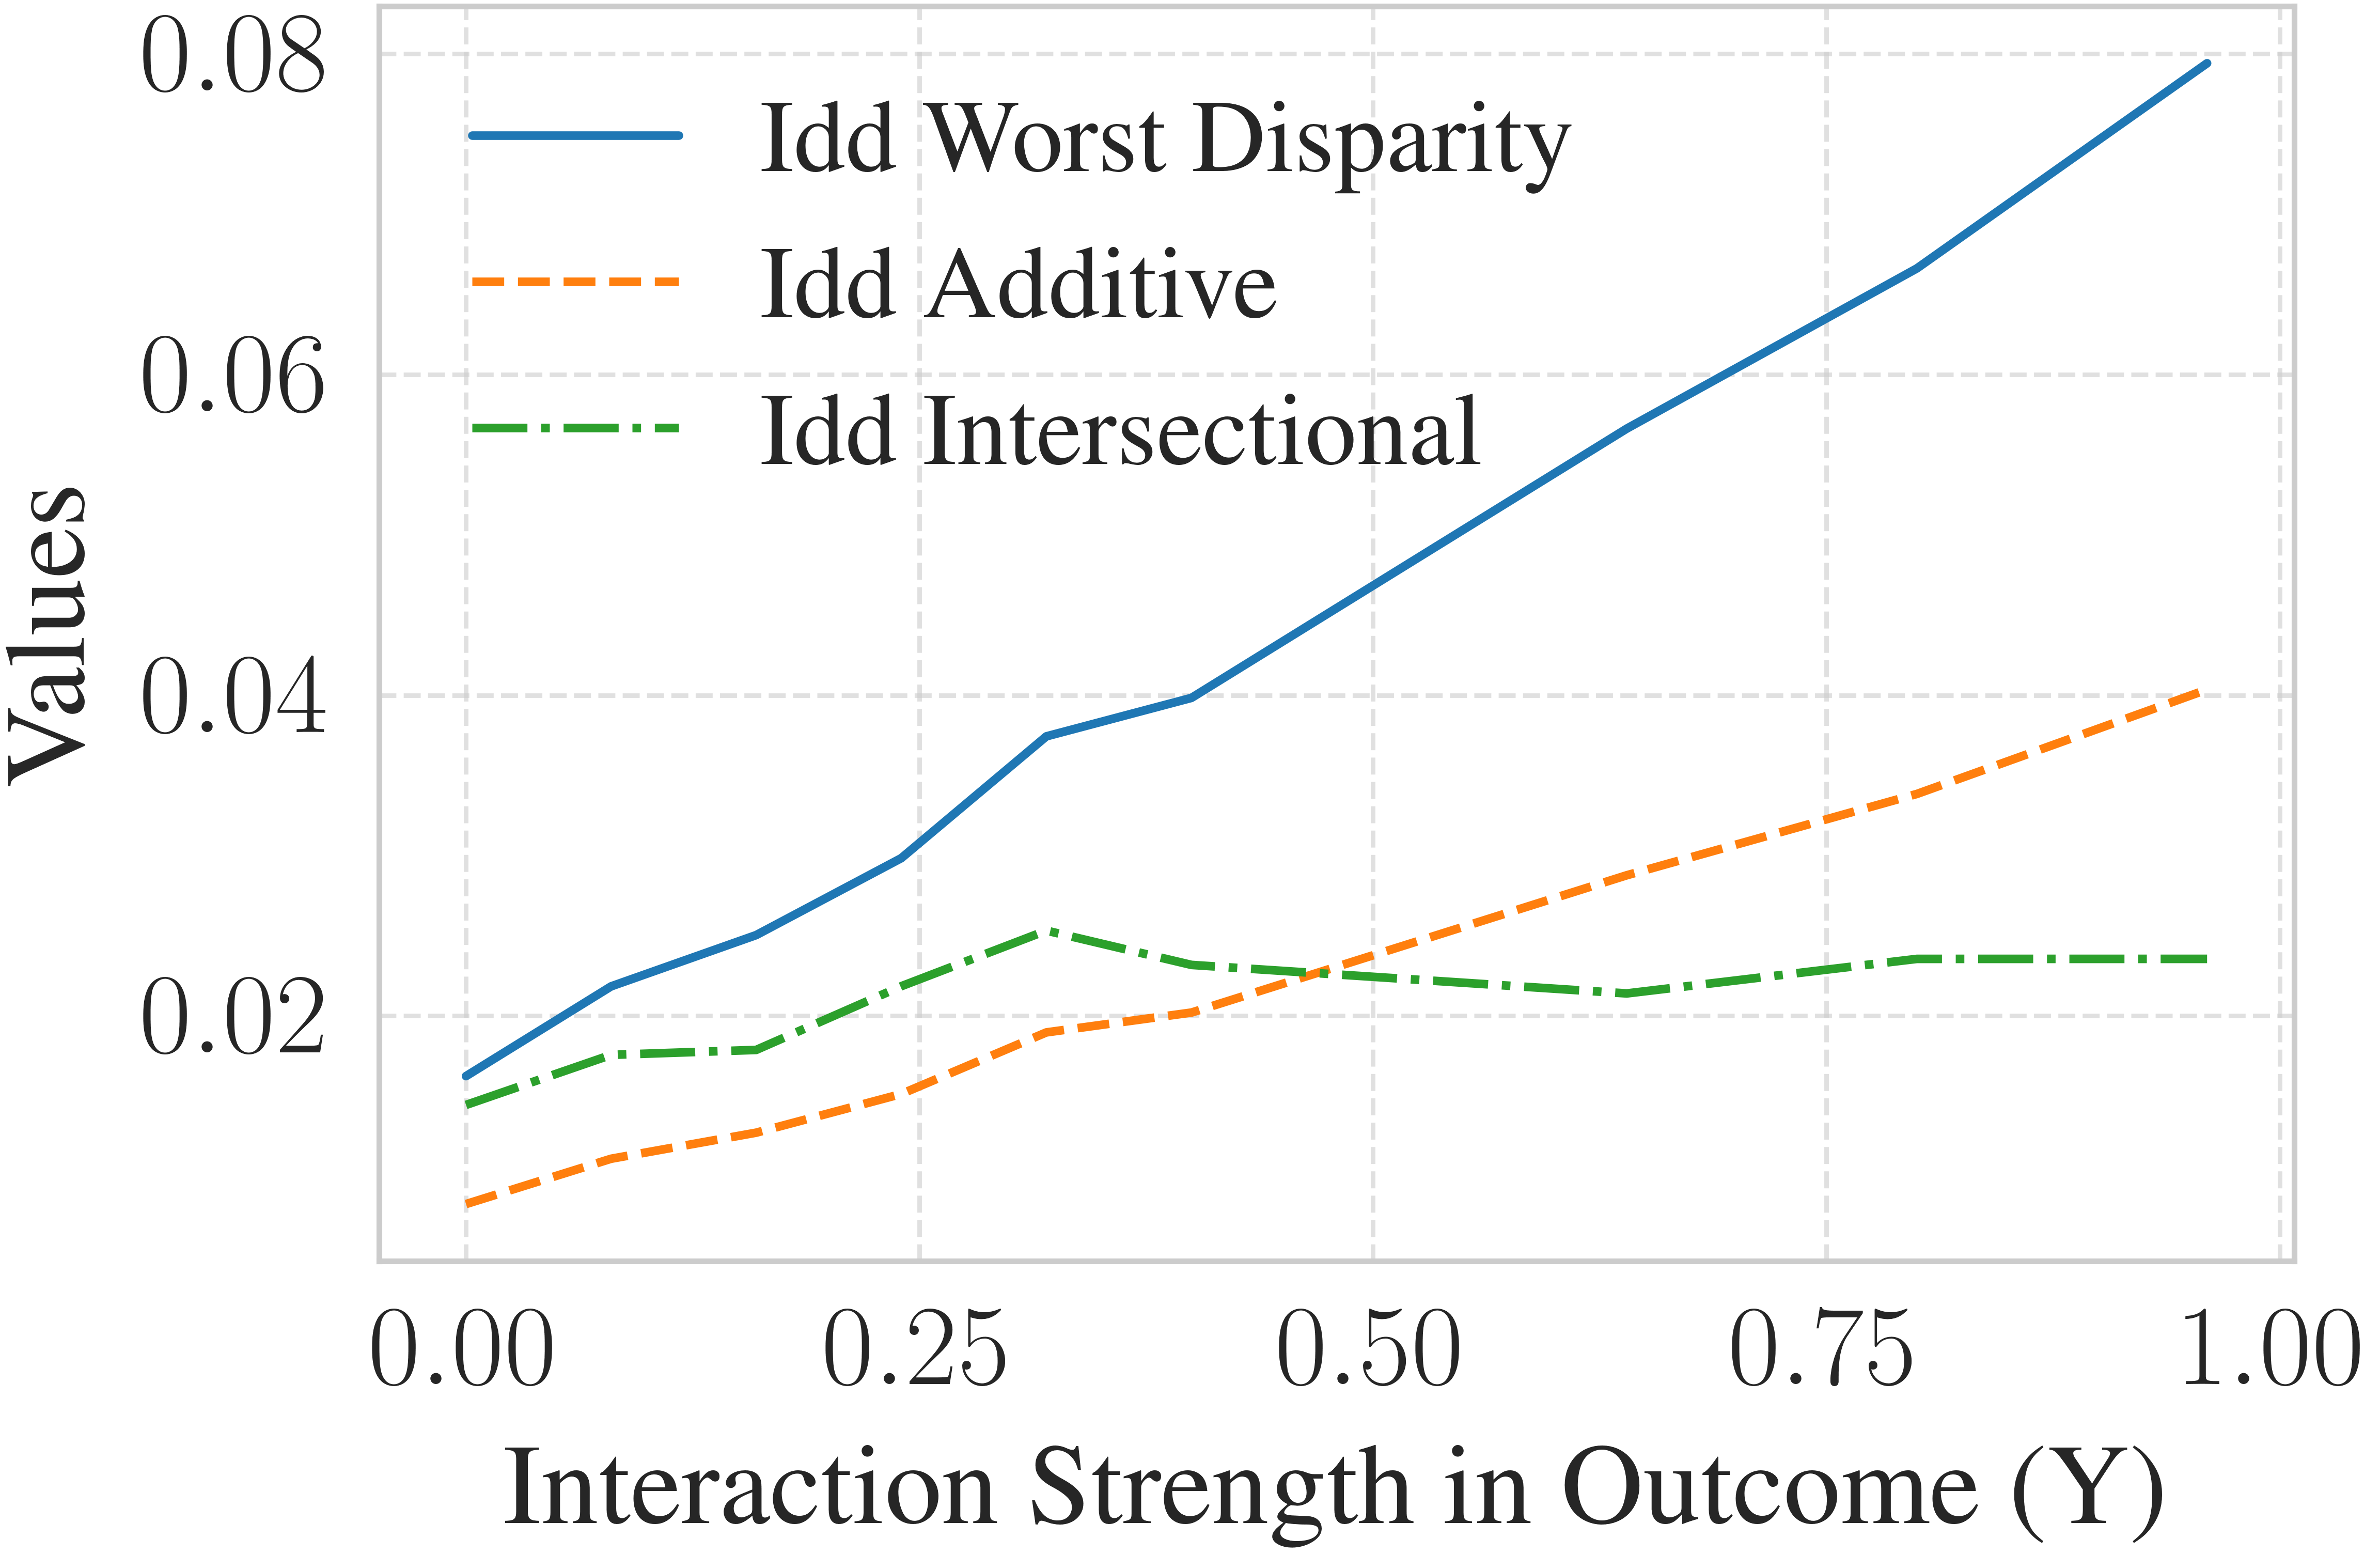

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))  

metrics_to_plot = [ 'idd_worst_disparity','idd_additive', 'idd_intersectional']

linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), '-', (0, (5, 1))]  

for metric, ls in zip(metrics_to_plot, linestyles):
    ax.plot(df_results_gender['Y'], df_results_gender[metric], label=metric.replace('_', ' ').title(), linestyle=ls, linewidth=1.5)

# Set axis labels
ax.set_xlabel(r"Interaction Strength in Outcome (Y)", labelpad=6, fontsize=20)
ax.set_ylabel(rf' Values', labelpad=6, fontsize=20)

# Set tick parameters
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

# Add grid and legend
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(loc='upper left', frameon=False, fontsize=18)

plt.tight_layout()

# Save figure
plt.savefig("single_sensitivity_gender.pdf", format='pdf', bbox_inches='tight')


###  Sensitivity to Interaction Effects

In [30]:

base_profile = {"E": 0.25, "I": 2.0, "L": 7.0, "D": 6.3, "Y": 0.8}
scales = [0, 0.1, 0.2,0.3, 0.4,  0.5, 0.8, 1.0, 1.2]
interaction_profiles = [
    {k: round(v * s, 2) for k, v in base_profile.items()} for s in scales]

outcome_col = 'Y'

In [31]:
sample_size = 10000
random_seed = 42
prob_gender = 0.5
prob_race = 0.5
beta_S = 0.6
beta_I = 0.8
beta = 0.03 # account influence of I, S in L
gamma = 0.10 # if set to 0 then no effect from sensitive attributes, 0.15
delta = 0.75  # influence of L, D in Y
eta = 2.0
plot_intersectional=True


all_results = []
for i, profile in enumerate(interaction_profiles):
    thetas = {'G': 0.0, 'R': 0.0, 'GR': profile['E']}
    beta_coef = {'G': 0.0, 'R': 0.0, 'GR': profile['I']}
    rhos = {'G': 0.0, 'R': 0.0, 'GR': profile['L']}
    kappas = {'G': 0.0, 'R': 0.0, 'GR': profile['D']}
    nus = {'G': 0.0, 'R': 0.0, 'GR': profile['Y']}
    lambdas = {'E': 1.0,'I': 1.0,'L': 1.0,'D': -1.0,'Y': 1.0}
    
    # Generate data and evaluate metrics
    generator = SyntheticLoanDataGenerator(
        sample_size=sample_size,
        random_seed=random_seed,
        prob_gender=prob_gender,
        prob_race=prob_race,
        beta=beta, beta_I=beta_I, beta_S=beta_S,
        gamma=gamma, eta=eta, delta=delta,
        measure_bias_col='Gender',
        thetas=thetas, beta_coef=beta_coef,
        rhos=rhos, kappas=kappas, nus=nus,
        lambdas=lambdas
    )

    data_intersectional = generator.synthetic_data_generation()
    intersectional_df = data_intersectional['data_df']
    # print(intersectional_df.columns)
    
    results_, subgroup_rates = metrics.evaluation_data(intersectional_df, sensitive_attributes, outcome_col, mode)
    # print(f"results for profile {profile}: {results_}")
    
    profile_results = profile.copy()  # E, I, L, D, Y
    profile_results.update(results_)  # Add metrics to the same dict
    all_results.append(profile_results)    
    
df_results_intersectional = pd.DataFrame(all_results)

# df_results = standardize_metrics(df_results, data_type='df', scalar_type=sensitivity_scaling_method, 
#                                         columns_to_scale=['demographic_disparity', 'elift', 'slift','subgroup_unfairness', 
#                                                           'idd_subgroups','idd_additive', 'idd_intersectional'])

    
df_results_intersectional.to_csv("interactional_metric_sweep.csv", index=False)


/var/folders/cf/xgy1fywj3q1bylrhvlp36psc0000gn/T/ipykernel_63330/1848029794.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


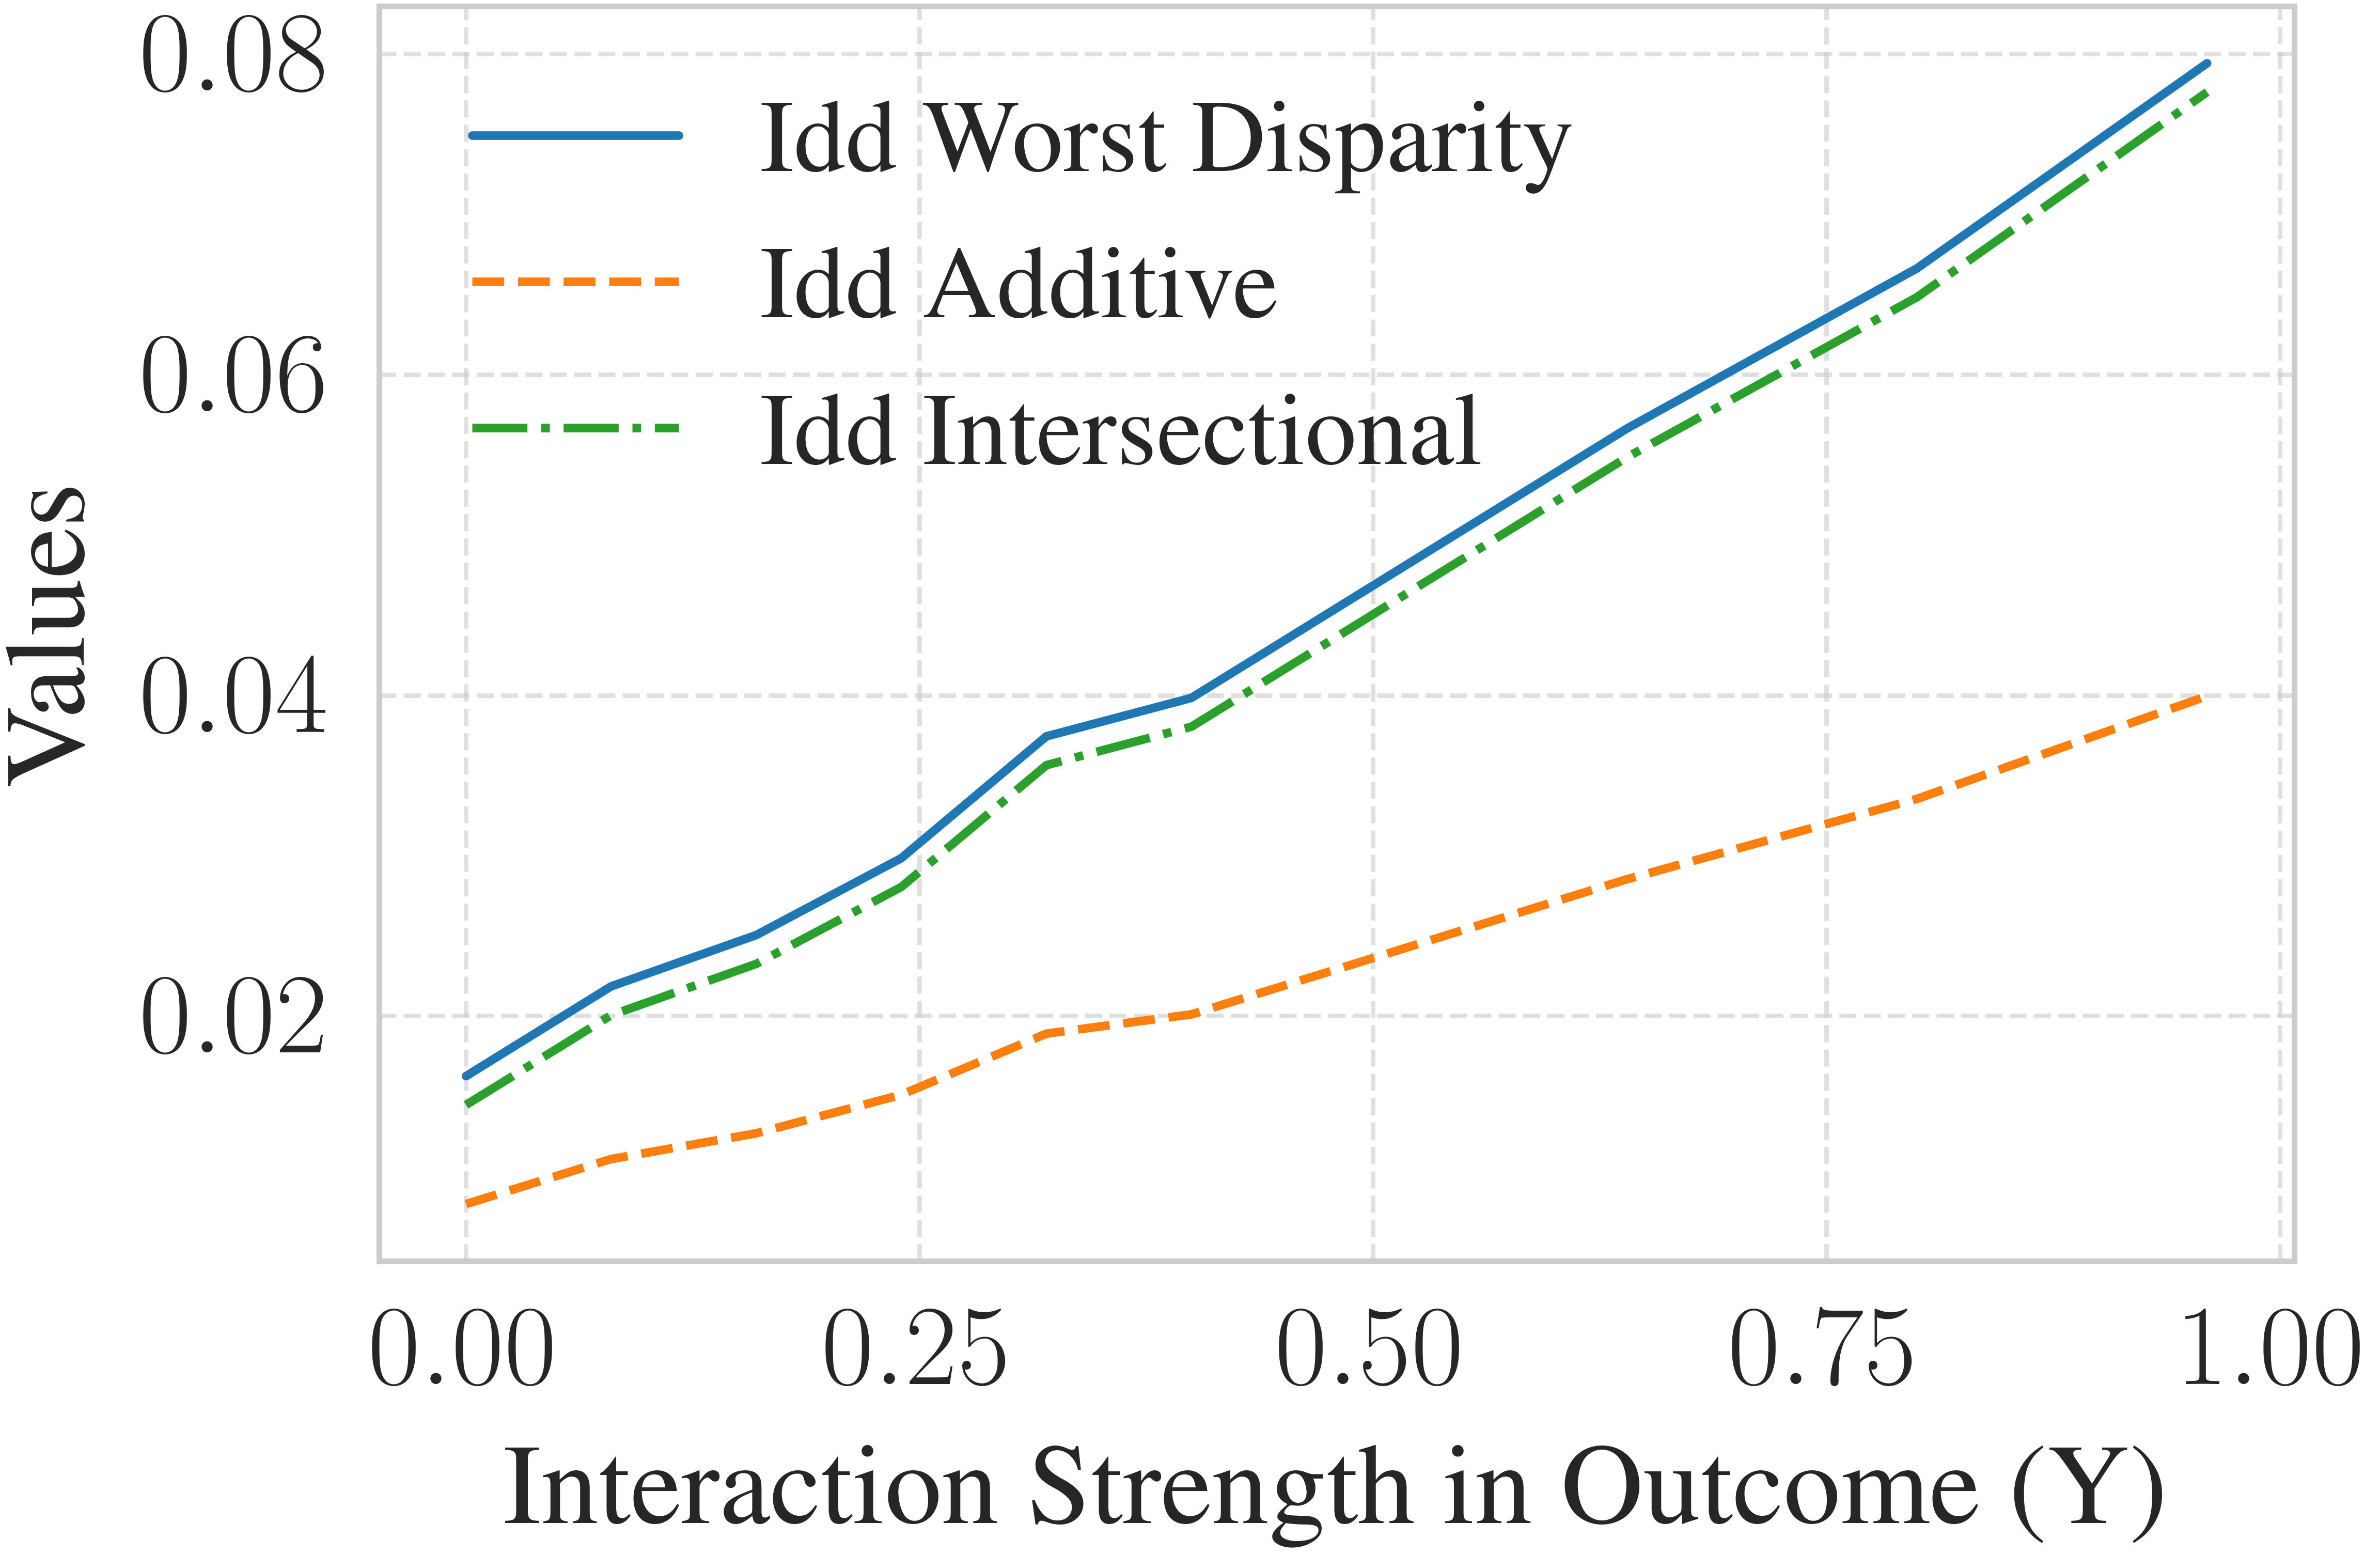

In [32]:
fig, ax = plt.subplots(figsize=(6, 4))  
# metrics_to_plot = ['demographic_disparity', 'elift', 'slift','subgroup_unfairness', 
#                                                           'idd_subgroups','idd_additive', 'idd_intersectional']

metrics_to_plot = ['idd_worst_disparity','idd_additive', 'idd_intersectional']
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), '-', (0, (5, 1))]  

for metric, ls in zip(metrics_to_plot, linestyles):
    ax.plot(df_results_intersectional['Y'], df_results_intersectional[metric], label=metric.replace('_', ' ').title(), linestyle=ls, linewidth=1.5)

# Set axis labels
ax.set_xlabel(r"Interaction Strength in Outcome (Y)", labelpad=6, fontsize=20)
ax.set_ylabel(rf'Values', labelpad=6, fontsize=20)

# Set tick parameters
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

# Add grid and legend
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(loc='upper left', frameon=False, fontsize=18)

plt.tight_layout()

# Save figure
plt.savefig("intersectional_sensitivity_plot_data.pdf", format='pdf', bbox_inches='tight')



### Sensitivity of Multiple 

In [33]:
base_profile_additive = {"E": 0.25, "I": 2.0, "L": 7.0, "D": 6.3, "Y": 0.8}
scales = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0, 1.2]

additive_profiles = [
    {k: round(v * s, 2) for k, v in base_profile_additive.items()} for s in scales]


all_results_additive = []
for profile in additive_profiles:
    thetas = {'G': profile['E'], 'R': profile['E'], 'GR': 0.0}
    beta_coef = {'G': profile['I'], 'R': profile['I'], 'GR': 0.0}
    rhos = {'G': profile['L'], 'R': profile['L'], 'GR': 0.0}
    kappas = {'G': profile['D'], 'R': profile['D'], 'GR': 0.0}
    nus = {'G': profile['Y'], 'R': profile['Y'], 'GR': 0.0}
    lambdas = {'E': 1.0, 'I': 1.0, 'L': 1.0, 'D': -1.0, 'Y': 1.0}

    generator = SyntheticLoanDataGenerator(
        sample_size=sample_size,
        random_seed=random_seed,
        prob_gender=prob_gender,
        prob_race=prob_race,
        beta=beta, beta_I=beta_I, beta_S=beta_S,
        gamma=gamma, eta=eta, delta=delta,
        measure_bias_col='Gender',
        thetas=thetas, beta_coef=beta_coef,
        rhos=rhos, kappas=kappas, nus=nus,
        lambdas=lambdas
    )

    data_additive = generator.synthetic_data_generation()
    additive_df = data_additive['data_df']
    results_, subgroup_rates = metrics.evaluation_data(additive_df, sensitive_attributes, outcome_col, mode)

    profile_results = profile.copy()
    profile_results.update(results_)
    all_results_additive.append(profile_results)

df_results_additive = pd.DataFrame(all_results_additive)

# df_results_additive = standardize_metrics(df_results_additive, data_type='df', scalar_type=sensitivity_scaling_method, 
#                                         columns_to_scale=['demographic_disparity', 'elift', 'slift','subgroup_unfairness', 
#                                                           'idd_subgroups','idd_additive', 'idd_intersectional'])

df_results_additive.to_csv("additive_metric_sweep.csv", index=False)


/var/folders/cf/xgy1fywj3q1bylrhvlp36psc0000gn/T/ipykernel_63330/1694386912.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


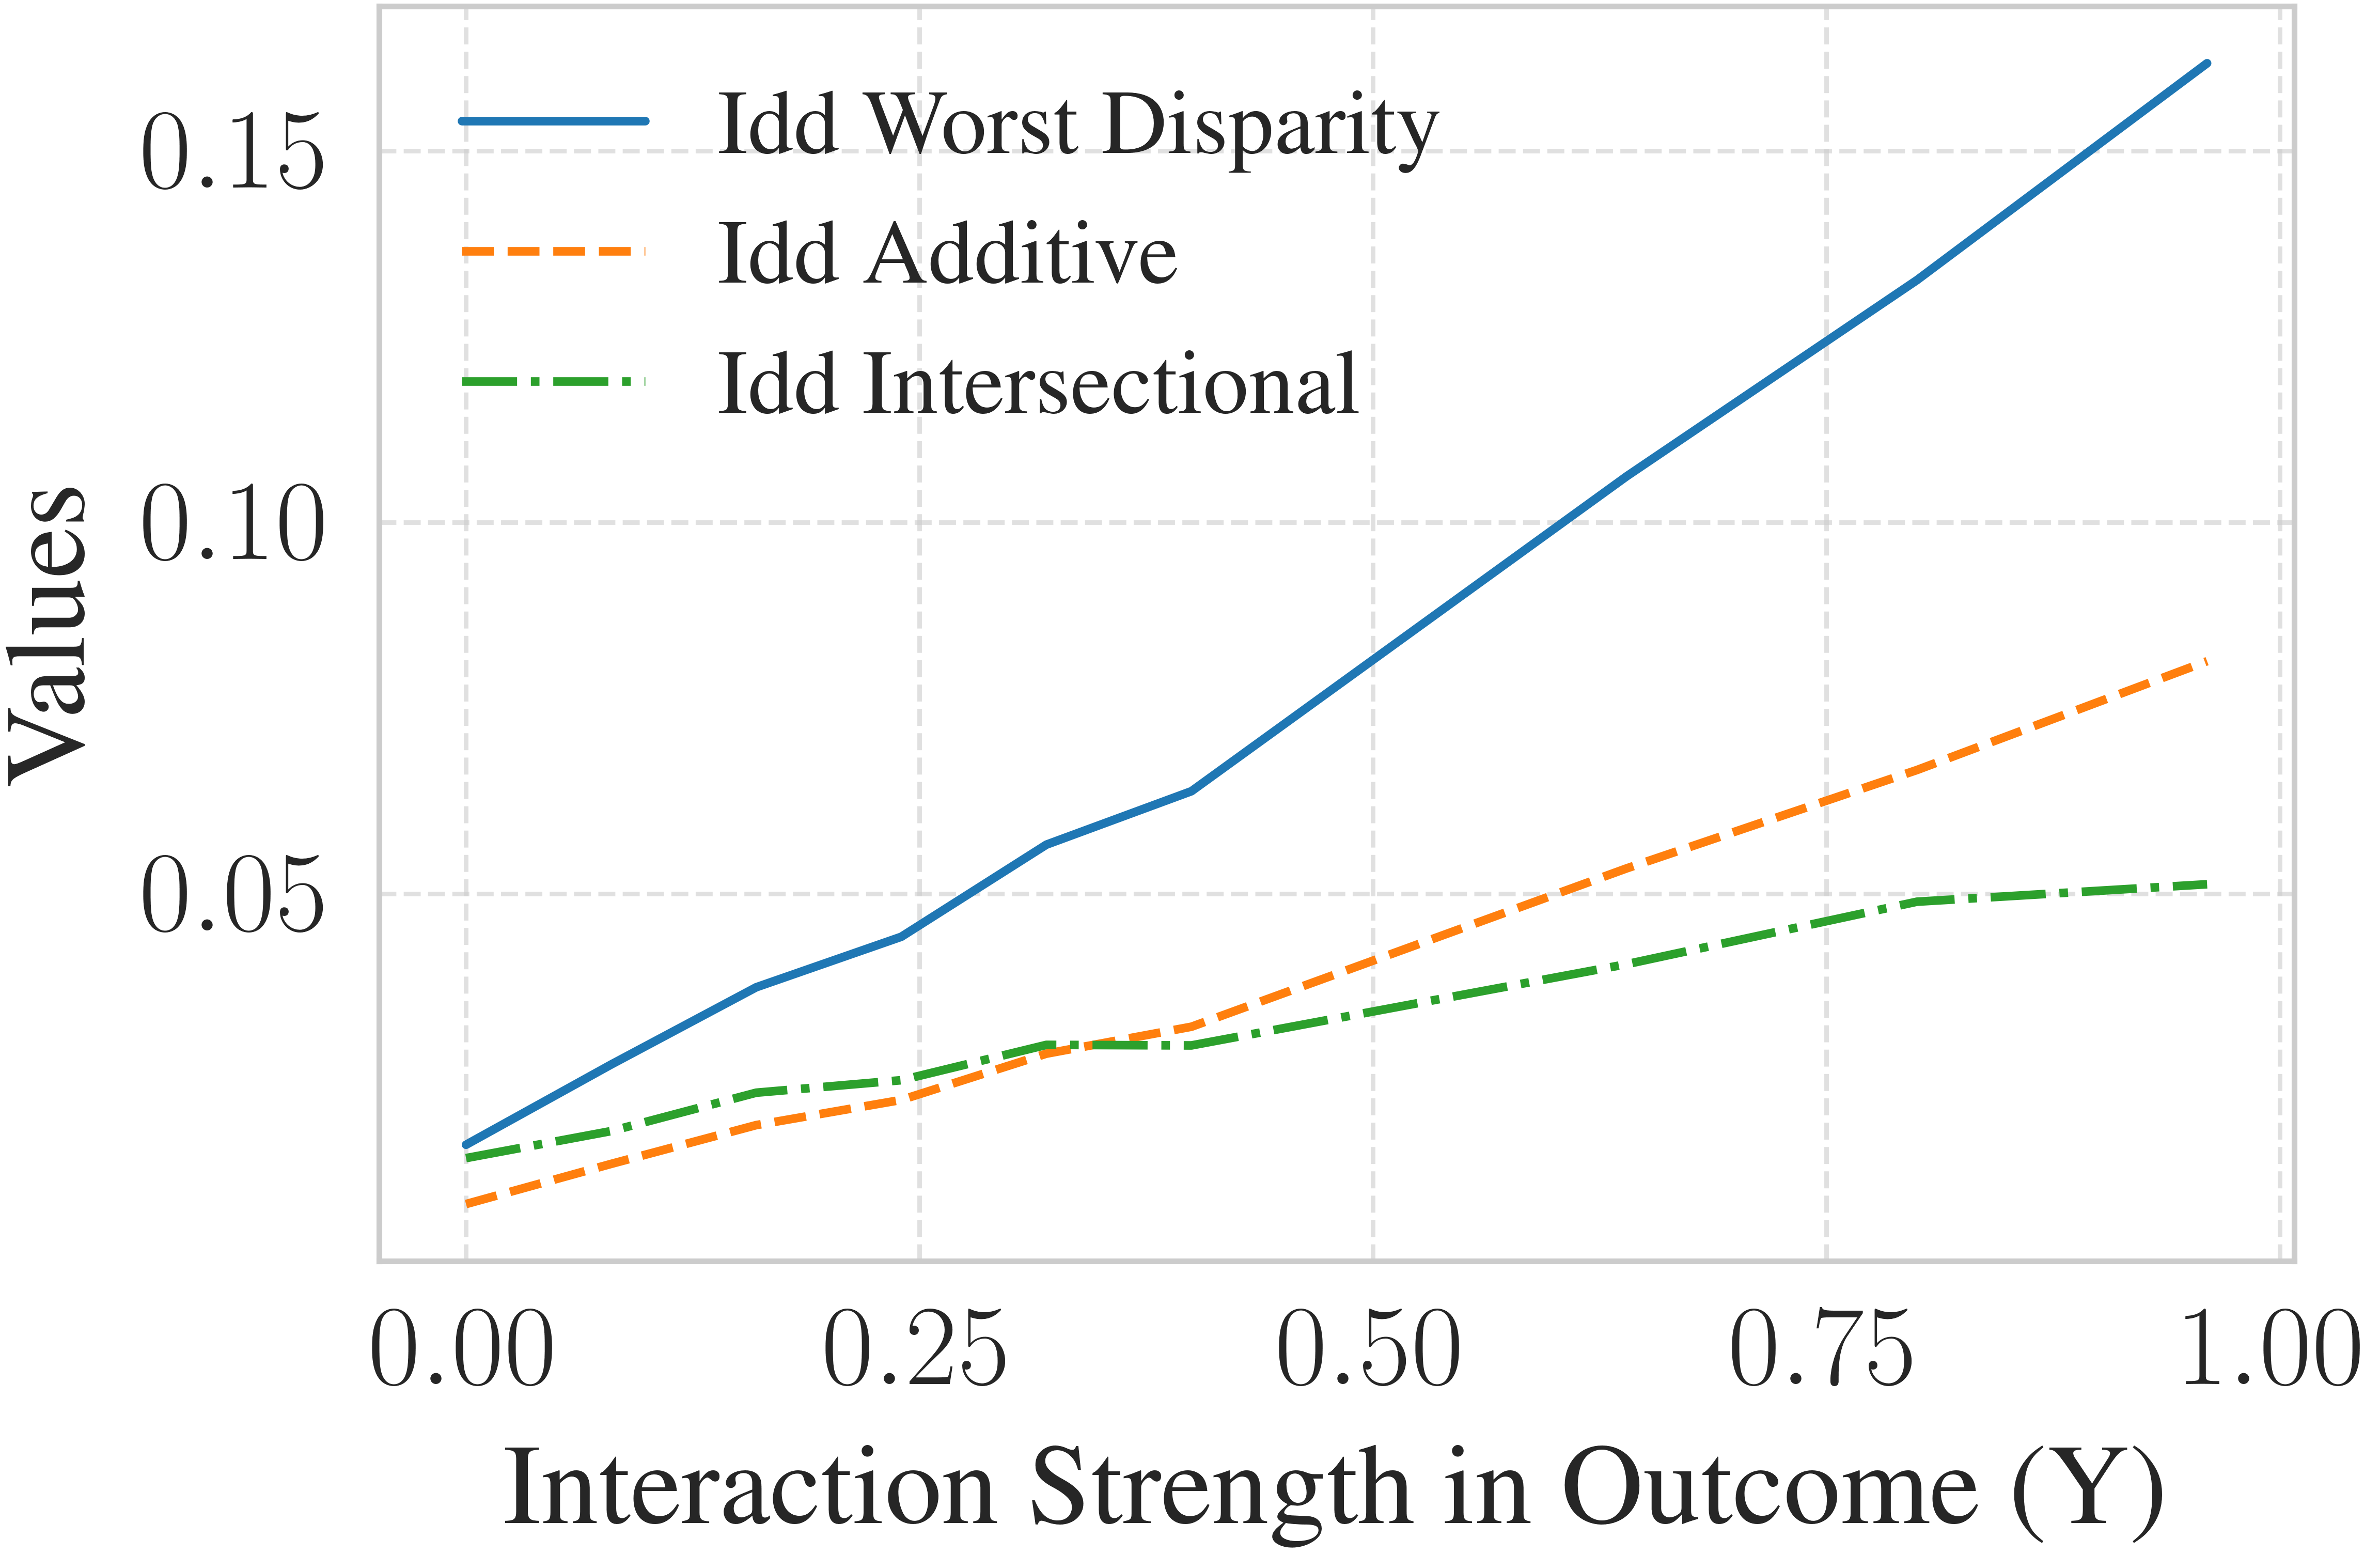

In [34]:

# Plotting
fig, ax = plt.subplots(figsize=(6, 4)) 

# metrics_to_plot = ['demographic_disparity', 'elift', 'slift','subgroup_unfairness', 
#                                                           'idd_subgroups','idd_additive', 'idd_intersectional']

metrics_to_plot = ['idd_worst_disparity','idd_additive', 'idd_intersectional']

linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), '-', (0, (5, 1))]  


for metric, ls in zip(metrics_to_plot, linestyles):
    ax.plot(df_results_additive['Y'], df_results_additive[metric], label=metric.replace('_', ' ').title(), linestyle=ls, linewidth=1.5)

# ax.set_xlabel(r'\textbf{Interaction Strength in Outcome (Y)}', labelpad=6, fontsize=20)

ax.set_xlabel(r"Interaction Strength in Outcome (Y)", labelpad=6, fontsize=20)
# ax.set_ylabel(r'\textbf{Scaled Scores}', labelpad=6, fontsize=18)
# ax.set_ylabel(rf'\textbf{{{sensitivity_scaling_method} scaled values}}', labelpad=6, fontsize=20)

ax.set_ylabel(rf'Values', labelpad=6, fontsize=20)


# ax.set_title(r'\textbf{Sensitivity to Outcome,  Multiple Discrimination}', pad=10, fontsize=18)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(loc='upper left', frameon=False, fontsize=16)
plt.tight_layout()

# Save figure
plt.savefig("additive_sensitivity_plot_data.pdf", format='pdf', bbox_inches='tight')